In [3]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

from urllib.request import urlopen
from pathlib import Path
from collections import defaultdict
from random import choice

## Carga de datos

In [4]:
red_lit = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_LIT.txt')
red_apms = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_AP-MS.txt')
red_bin = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_Y2H.txt')

In [5]:
escenciales = open('./Datos/Essential_ORFs_paperHe2.txt')
lista_escenciales = []

for line in escenciales:
    lista_escenciales.append(line.rstrip('\n'))

In [6]:
def nodos_esenciales(red, lista_atr = lista_escenciales, atributo = 'Esencial'):
    
    dict_vacio = dict()
    nx.set_node_attributes(red, dict_vacio.fromkeys(list(red.nodes()),0), atributo )
    
    for nodo in lista_atr:
        try:
            red.nodes[nodo][atributo] = 1
        except KeyError:
            continue
            
    return None

In [7]:
nodos_esenciales(red_lit)
nodos_esenciales(red_bin)
nodos_esenciales(red_apms)

In [8]:
redes = [red_lit, red_apms, red_bin]
sRed = ['Red Literatura', 'Red AP-MS', 'Red Y2H']

In [9]:
def probEsencial(red, grado):
    count = 0
    n = 0
    for nodo in red.nodes:
        if (red.degree[nodo] - grado): continue
        n += 1
        count += red.nodes.data()[nodo]['Esencial']
    return (count/n)

In [39]:
def contarPares(red, alpha, beta):
    nodos = list(red.degree)
    A = nx.adjacency_matrix(red).toarray()
    A2 = np.matmul(A,A)
    matrizPares = (((A2>=3).astype(int)-np.identity(red.number_of_nodes())-A)>0).astype(int)
    coordsPares = np.where(matrizPares == 1)
    numPares = int(len(coordsPares[0]) / 2)
    numParesTipo = 0
    probMismoTipo = 0
    for nodo1, nodo2 in zip(*coordsPares):
        if (nodo1 > nodo2): continue
        k1 = nodos[nodo1][1]
        k2 = nodos[nodo2][1]
        P1NE = (1-beta)*((1-alpha)**k1)
        P2NE = (1-beta)*((1-alpha)**k2)
        probMismoTipo += (P1NE*P2NE + (1-P1NE)*(1-P2NE))
        numParesTipo += int(red.nodes.data()[nodos[nodo1][0]]['Esencial'] == red.nodes.data()[nodos[nodo2][0]]['Esencial'])
    return [numPares, numParesTipo, probMismoTipo]

Red Literatura
Alpha = 6.36%
Beta = 29.99%
p-valor = 0.0027
Red AP-MS
Alpha = 2.54%
Beta = 27.36%
p-valor = 0.2535
Red Y2H
Alpha = 1.47%
Beta = 18.22%
p-valor = 0.2125


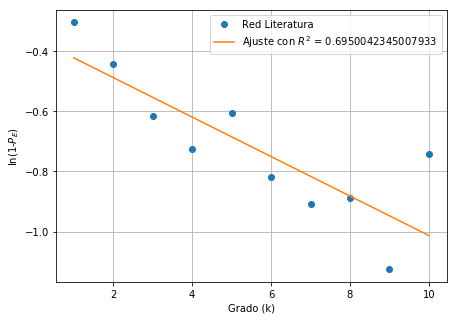

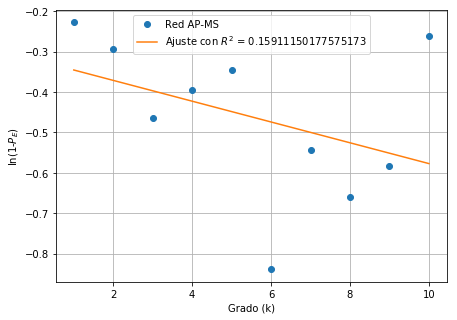

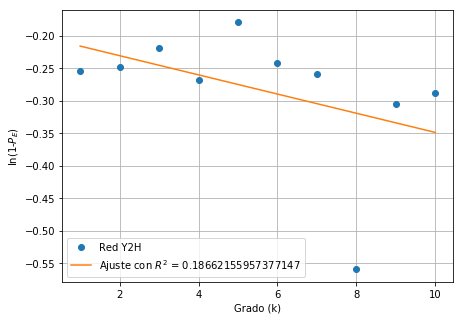

In [11]:
g = list(range(1,11))
alpha = [float, float, float]
beta = [float, float, float]
for i, red in enumerate(redes):
    lnp = []
    for grado in range(1,11):
        lnp.append(np.log(1-probEsencial(red,grado)))
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(g,lnp)
    alpha[i] = 1 - np.exp(slope)
    beta[i] = 1 - np.exp(intercept)
    
    plt.figure(figsize=(7,5))
    plt.plot(g,lnp,'o',label=sRed[i])
    plt.plot(g,[slope*x+intercept for x in g],label=('Ajuste con $R^2$ = ' + str(r_value**2)))
    plt.title('')
    plt.xlabel('Grado (k)')
    plt.ylabel('ln(1-$P_E$)')
    plt.legend()
    plt.grid(True)
    print (sRed[i])
    print ("Alpha = " + str(round(alpha[i]*100,2)) + "%")
    print ("Beta = " + str(round(beta[i]*100,2)) + "%")
    print ("p-valor = " + str(round(p_value,4)))

In [44]:
cols = ['Número total de pares', 'Número de pares del mismo tipo', 'Número esperado de pares del mismo tipo']
tabla = pd.DataFrame(np.nan, columns = cols, index = sRed)
d = [list(),list(),list()]
for i, red in enumerate(redes):
    d[i] = contarPares(red, alpha[i], beta[i])
    for j, col in enumerate(cols):
        tabla.loc[sRed[i]][col] = d[i][j]
tabla

################## IMPORTANTE ###################
## HAY QUE SACAR LA RED AP-MS Y PONER LA OTRA ##

,Número total de pares,Número de pares del mismo tipo,Número esperado de pares del mismo tipo
Red Literatura,730.0,389.0,385.632502
Red AP-MS,11613.0,5907.0,6430.764048
Red Y2H,522.0,352.0,291.604116
